In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import timm
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.utils.data.sampler import SubsetRandomSampler
from cv import Cadence
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.nn import ReLU, Conv2d, MaxPool2d, BatchNorm1d, BatchNorm2d
from ignite.metrics import Recall, Precision, Accuracy

In [9]:
torch.cuda.empty_cache()

### Config

In [10]:
conf_dict = {
    "batch_size": 4,
    "learn_rate": 1e-3,
    "min_learn_rate": 1e-6,
    "weight_decay": 1e-4,
    "epochs": 20,

    "transfer_model_name": "efficientnet_b0", #"tf_efficientnet_b5_ns", #

    "train_dir": "../data/train/",
    "train_csv": "train_labels.csv",
    "test_dir": "../data/test/",
    "test_csv": "sample_submission.csv",
    "height": 512,
    "width": 512,

    "model": "schnaufnet_trained.pth",

    "origin_height": 273,
    "origin_width": 256,

    "only_use": 1000,
    "behaviours": {
        "all": "use_all",
        "only_1": "only_1",
        "50_50": "50_50",
    }
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


### Custom Dataset

In [11]:
class SETIDataset(Dataset):
	"""Dataset for training data"""
	def __init__(self, img_dir, test=False, transform=None, target_transform=None, use_cv_preprocessing=False):
		self.test = test
		if not self.test:
			self.img_labels = pd.read_csv(img_dir + conf_dict["train_csv"])
		else:
			self.img_labels = pd.read_csv(img_dir + conf_dict["test_csv"])
		self.img_labels['file_path'] = self.img_labels['id'].apply(self.get_file_path, dir=img_dir)
		self.img_dir = img_dir
		self.file_names = self.img_labels['file_path'].values
		self.transform = transform
		self.target_transform = target_transform
		self.use_cv_preprocessing = use_cv_preprocessing

	def __len__(self):
		return len(self.img_labels)

	def __getitem__(self, idx):
		file_path = self.file_names[idx]
		image = np.load(file_path)
		image = image.astype(np.float32)

		if self.use_cv_preprocessing:
			cadence = Cadence(file_path)
			cadence.cv()

		image = np.vstack(image).T

		if self.transform:
			image = self.transform(image=image)['image']
		else:
			image = image[np.newaxis,:,:] # add dimension
			image = torch.from_numpy(image).float()

		label = torch.tensor(self.img_labels["target"][idx]).float()

		# image = image.repeat(3, 1, 1) # TODO: probably just repeating the single channel isnt the best way => probably converting grayscale to rgb is better

		return image, label

	def get_file_path(self, image_id, dir):
		return dir + "{}/{}.npy".format(image_id[0], image_id)


In [12]:
network_conf_dict = {
    "conv_1_filter_output": 8,
    "conv_2_filter_output": 16,
    "conv_3_filter_output": 16,
}

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.1)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(network_conf_dict["conv_3_filter_output"] * 64 * 64, 32),
            nn.ReLU(),
            BatchNorm1d(32),
            nn.Linear(32, 32),
            nn.ReLU(),
            BatchNorm1d(32),
            nn.Linear(32, 1),
        )
        self.simple_cnn_stack = nn.Sequential(
            Conv2d(3, network_conf_dict["conv_1_filter_output"], kernel_size=3, stride=1, padding=1),
            BatchNorm2d(network_conf_dict["conv_1_filter_output"]),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(network_conf_dict["conv_1_filter_output"], network_conf_dict["conv_2_filter_output"], kernel_size=3, stride=1, padding=1),
            BatchNorm2d(network_conf_dict["conv_2_filter_output"]),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(network_conf_dict["conv_2_filter_output"], network_conf_dict["conv_3_filter_output"], kernel_size=3, stride=1, padding=1),
            BatchNorm2d(network_conf_dict["conv_3_filter_output"]),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

    def forward(self, x):
        x = self.simple_cnn_stack(x)
        x = self.flatten(x)
        x = self.dropout(x)
        logits = self.linear_relu_stack(x)
        return logits

class NeuralNetworkWithBackbone(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(conf_dict["transfer_model_name"], pretrained=pretrained, in_chans=1)
        self.backbone.classifier = nn.Linear(self.backbone.classifier.in_features, 1)

    def forward(self, x):
        return self.backbone(x)


In [13]:
class SETITrainValidation():
    def __init__(self, train_dir, test_dir, load_model=False, val_split=0.25, use_backbone=True):
        self.dataset_whole_train = SETIDataset(train_dir, transform=self.get_transforms(data="train"))#, use_cv_preprocessing_preprocessing=True)
        self.dataset_whole_val = SETIDataset(train_dir, transform=self.get_transforms(data="val"))#, use_cv_preprocessing=True) # extra dataset für validation, da validation data nicht transformiert werden darf
        # self.dataset_test = SETIDataset(test_dir, test=True, transform=self.get_transforms(data="test"), use_cv_preprocessing=True)
        if load_model:
            self.model = self.load_model(use_backbone)
        else:
            self.model = self.new_model(use_backbone)
        self.loss_fn = nn.BCEWithLogitsLoss().to(device) # nn.BCELoss().to(device) => needs sigmoid as last layer
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=conf_dict["learn_rate"], weight_decay=conf_dict["weight_decay"]) # torch.optim.SGD(self.model.parameters(), lr=conf_dict["learn_rate"]) 
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer, T_max=conf_dict["epochs"], eta_min=conf_dict["min_learn_rate"], last_epoch=-1
        )

        self.val_split = val_split
        self.train_dataloader = None
        self.val_dataloader = None
        self.train_losses = []
        self.train_acc = []
        self.val_losses = []
        self.val_acc = []
        self.accuracy = Accuracy()
        self.precision = Precision()
        self.recall = Recall()


    def get_transforms(self, data):
        if data == 'train':
            return A.Compose([
                A.Resize(conf_dict["height"], conf_dict["width"]),
                A.VerticalFlip(p=0.5),
                A.HorizontalFlip(p=0.5),
                ToTensorV2(),
            ])
        elif data == 'val' or data == 'test':
            return A.Compose([
                A.Resize(conf_dict["height"], conf_dict["width"]),
                ToTensorV2()
            ])

    def split(self, behaviour="all", shuffle=True, use_all=True):
        dataset_whole_size = len(self.dataset_whole_train)
        if use_all:
            val_range = int(np.floor(self.val_split * dataset_whole_size))
        else:
            val_range = int(np.floor(self.val_split * conf_dict["only_use"]))
        train_range = dataset_whole_size - val_range

        train_set, val_set = torch.utils.data.random_split(self.dataset_whole_train, [train_range, val_range])
        if behaviour == conf_dict["behaviours"]["only_1"]:
            indices_1_labels = [i for i in range(dataset_whole_size) if self.dataset_whole_train.img_labels["target"][i] == 1]
            train_sampler = SubsetRandomSampler(indices_1_labels)
            self.train_dataloader = DataLoader(self.dataset_whole_train, batch_size=conf_dict["batch_size"], sampler=train_sampler)
        elif behaviour == conf_dict["behaviours"]["50_50"]:
            indices_1_labels = [i for i in range(dataset_whole_size) if self.dataset_whole_train.img_labels["target"][i] == 1]
            indices_0_labels = [i for i in range(dataset_whole_size) if self.dataset_whole_train.img_labels["target"][i] == 0]
            indices_0_labels_for_50_50 = list(np.random.choice(len(indices_0_labels), len(indices_1_labels), replace=False))
            indices_50_50 = indices_1_labels + indices_0_labels_for_50_50
            train_sampler = SubsetRandomSampler(indices_50_50)
            self.train_dataloader = DataLoader(self.dataset_whole_train, batch_size=conf_dict["batch_size"], sampler=train_sampler)
        elif behaviour == conf_dict["behaviours"]["all"]:
            self.train_dataloader = DataLoader(train_set, batch_size=conf_dict["batch_size"], shuffle=shuffle)#, num_workers=2)
        self.val_dataloader = DataLoader(val_set, batch_size=conf_dict["batch_size"], shuffle=shuffle)#, num_workers=2)

        print(f"Successfully splitted dataset!\n Trainbatches: {len(self.train_dataloader)}\n Validationbatches: {len(self.val_dataloader)}")
    
    def train_loop(self):
        print("Starting model training...")
        self.model.train()
        print("Finished pretraining model...")
        num_batches = len(self.train_dataloader)
        epoch_loss = 0
        for batch, (image, label) in enumerate(self.train_dataloader):
            image = image.to(device)
            label = label.to(device)
            pred = self.model(image)
            loss = self.loss_fn(pred, label.to(torch.float32).unsqueeze(1))
            epoch_loss += loss.item() # add loss for whole batch

            # Backpropagation
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            predicted = torch.sigmoid(pred).round() # if precision gets higher => write own function which does not seperate <0.5 and >=0.5 like round currently does
            self.accuracy.update((predicted, label))
            self.precision.update((predicted, label))
            self.recall.update((predicted, label))

        avg_epoch_loss = epoch_loss / num_batches
        self.train_losses.append(avg_epoch_loss)
        self.train_acc.append(100*self.accuracy.compute())
        print(f"""Test Error: \n 
            Accuracy: {100*self.accuracy.compute():>2f}%, \n
            Recall: {100*self.recall.compute():>2f}%, \n
            Precision: {100*self.precision.compute():>2f}%, \n
            Avg loss: {avg_epoch_loss:>2f} \n
        """) # avg loss is summed losses for all batches divided with num batches

    def validation_loop(self):
        print("Starting model validation...")
        num_batches = len(self.val_dataloader)
        epoch_loss = 0

        with torch.no_grad():
            for batch, (image, label) in enumerate(self.val_dataloader):
                image = image.to(device)
                label = label.to(device)
                pred = self.model(image)
                loss = self.loss_fn(pred, label.to(torch.float32).unsqueeze(1)).item()
                epoch_loss += loss.item()

                predicted = torch.sigmoid(pred).round()

                self.accuracy.update((predicted, label))
                self.precision.update((predicted, label))
                self.recall.update((predicted, label))

        avg_epoch_loss = epoch_loss / num_batches
        self.val_losses.append(avg_epoch_loss)
        self.val_acc.append(100*self.accuracy.compute())
        print(f"""Test Error: \n 
            Accuracy: {100*self.accuracy.compute():2f}%, \n
            Recall: {100*self.recall.compute():2f}%, \n
            Precision: {100*self.precision.compute():>2f}%, \n
            Avg loss: {avg_epoch_loss:>2f} \n
        """)

    def load_model(self, use_backbone, pretrained=True):
        self.model = self.new_model(use_backbone, pretrained)
        self.model.load_state_dict(torch.load(conf_dict["model"]))
        self.model.eval()
        return self.model

    def save_model(self):
        print("Training done! Saving model...")
        torch.save(self.model.state_dict(), conf_dict["model"])
        print("Saved model!")

    def new_model(self, use_backbone, pretrained=True):
        if use_backbone:
            # model = timm.create_model(
            #     model_name=conf_dict["transfer_model_name"], 
            #     num_classes=1,
            #     pretrained=False,
            # ).to(device)
            # print("Using resnet...")
            # model = torchvision.models.resnet18(
            #     pretrained=True,
            # )
            # model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,bias=False)
            # model.avgpool = nn.AdaptiveAvgPool2d(1)
            # model.fc = nn.Linear(512 * torchvision.models.resnet.BasicBlock.expansion, 1)
            # return model.to(device)
            backbone = conf_dict["transfer_model_name"]
            print(f"Using {backbone} Network...")
            return NeuralNetworkWithBackbone(pretrained).to(device)
        else: 
            return NeuralNetwork().to(device)

    def plot_loss_acc_vs_epochs(self, train=True, plot_loss=True):
        if train:
            if plot_loss:
                vs = "Loss"
                plt.plot(self.train_losses, "ro-")
            else:
                vs = "Accuracy"
                plt.plot(self.train_acc, "ro-")
        else:
            if plot_loss:
                vs = "Loss"
                plt.plot(self.val_losses, "ro-")
            else:
                vs = "Accuracy"
                plt.plot(self.val_acc, "ro-")
        plt.title(vs + " vs Epochs")
        plt.xlabel("Epochs")
        plt.ylabel(vs)
        plt.show()

    def train_model(self):
        num_epochs = conf_dict["epochs"]
        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}\n-------------------------------")
            self.train_loop()
        self.plot_loss_acc_vs_epochs(train=True, plot_loss=True)
        self.plot_loss_acc_vs_epochs(train=True, plot_loss=False)
        self.save_model()

    def validate_model(self):
        self.load_model()
        # num_epochs = conf_dict["epochs"]
        # for epoch in range(num_epochs):
        #     print(f"Epoch {epoch+1}/{num_epochs}\n-------------------------------")
        seti_trainer.validation_loop()
        self.plot_loss_acc_vs_epochs(train=False, plot_loss=True)
        self.plot_loss_acc_vs_epochs(train=False, plot_loss=False)
        

Using efficientnet_b0 Network...
Successfully splitted dataset!
 Trainbatches: 3000
 Validationbatches: 3750
Epoch 1/20
-------------------------------
Starting model training...
Finished pretraining model...
Test Error: 
 
            Accuracy: 56.600000%, 

            Recall: 66.787714%, 

            Precision: 59.431803%, 

            Avg loss: 0.676215 

        
Epoch 2/20
-------------------------------
Starting model training...
Finished pretraining model...
Test Error: 
 
            Accuracy: 59.966667%, 

            Recall: 64.858526%, 

            Precision: 63.334811%, 

            Avg loss: 0.619223 

        
Epoch 3/20
-------------------------------
Starting model training...
Finished pretraining model...
Test Error: 
 
            Accuracy: 61.683333%, 

            Recall: 63.907802%, 

            Precision: 65.622249%, 

            Avg loss: 0.587637 

        
Epoch 4/20
-------------------------------
Starting model training...
Finished pretraining model...

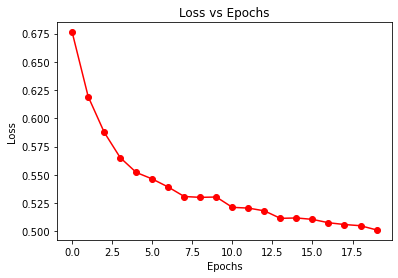

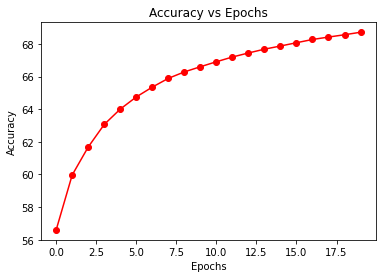

Training done! Saving model...
Saved model!


In [14]:
seti_trainer = SETITrainValidation(conf_dict["train_dir"], conf_dict["test_dir"], load_model=False, use_backbone=True)
seti_trainer.split(behaviour=conf_dict["behaviours"]["50_50"], use_all=True)
seti_trainer.train_model()
# seti_trainer.validate_model()